<a href="https://colab.research.google.com/github/hvhq/appcomponents/blob/main/ncov_AppliedMath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [275]:
import requests as rqs
import pandas as pd
import numpy as np
import csv
from datetime import datetime, date, timedelta
import random
import matplotlib.pyplot as plt

firstDay = "2021-04-27"
lastDay = "2021-07-05"

In [166]:
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/by-current?start_time="+firstDay+"&end_time="+lastDay)

responseJsonList = response.json()
table = [["ma_tinh", "tinh","ngay","so_ca"]]
countSpreadRate = 0
sumSpreadRate = 0.0
for province in responseJsonList:
  col0 = province["id"]
  col1 = province["tinh"]
  data = province["data"]
  prevInfected = 1
  for datarow in data:
    row = [col0, col1, datarow, data[datarow]]
    table.insert(len(table), row)
    #calc spread rate
    if data[datarow] / prevInfected>0.01:
      countSpreadRate += 1
      sumSpreadRate += data[datarow] / prevInfected
    prevInfected = data[datarow]
    if prevInfected == 0:
      prevInfected = 1

with open("covid-province-data-daily.csv",  "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(table)

#average spread rate
sumSpreadRate = sumSpreadRate/countSpreadRate
print(sumSpreadRate)


2.2913051482816846


In [46]:
from google.colab import files
import csv

#Load Data
#Load population data
files.upload()
with open('danso2019.csv', newline='') as csvfile:
    populations = list(csv.reader(csvfile))
print(populations[0])
print(populations[2])
#Load covid data
files.upload()
with open('covid-province-data-daily.csv', newline='') as csvfile:
    covid = list(csv.reader(csvfile))
print(covid[0])
print(covid[2])

Saving flight-data-daily.csv to flight-data-daily (1).csv
['day', 'sairport', 'eairport', 'gate', 'scheduled_time', 'flight_no', 'status', 'seats', 'fill_rate']
['2021-04-27', 'PQC', 'VCA', '2', '10:00', 'QH2182', 'CLS', '124', '']


Saving danso2019.csv to danso2019 (1).csv
['tinh', 'dan_so', 'ma_vung', 'ten_vung']
['Vĩnh Phúc', '1154,8', '1', 'Bắc Bộ']


Saving covid-province-data-daily.csv to covid-province-data-daily.csv
['tinh', 'dan_so', 'ma_vung', 'ten_vung']
['Vĩnh Phúc', '1154,8', '1', 'Bắc Bộ']


In [147]:
#Dictionary contain areaCode of province
areaCodeDictionary = {}
#Dan so cua 6 vung
areaPopulation = np.array([0,0,0,0,0,0])
print(len(populations))
for row in range(1,len(populations)):
  areaPopulation[int(populations[row][2]) - 1] += 1000 * float(populations[row][1].replace(",","."))
  areaCodeDictionary[populations[row][0]] = int(populations[row][2])
print("Population 2019:",areaPopulation)
#calculate end of 2020 population, roughly 2021 population
increaseRate = [1.33, 0.69, 0.69, 1.33, 2.57, 0.05]
for areaCode in range(0, 6):
  areaPopulation[areaCode] = areaPopulation[areaCode] * (1+increaseRate[areaCode]/100)
print("Population 2020: ", areaPopulation)
print("Vietnam population 2020 (calculated):",sum(areaPopulation))
print("Vietnam population end of 2020 (government stats):", 97.58 , "million")
print("So we can assume that in started months of year 2021,\n\t "
      +"population has slightly increase from 97.58 million to 97.638 milion,\n\t "
      +"so we can use that population for started months of 2021 (now) instead of 2020,\n\t"
      +"the error can be tolerated")
#Theo uoc tinh cua tong cuc thong ke, cuoi nam 2020, dan so VietNam khoang 97.58 trieu nguoi
#Điều này xác nhận tính toán của chúng ta là gần đúng 97.638, có thể chấp nhận

64
Population 2019: [35189500 10932800  9287600  5861300 17930300 17282500]
Population 2020:  [35657520 11008236  9351684  5939255 18391108 17291141]
Vietnam population 2020 (calculated): 97638944
Vietnam population end of 2020 (government stats): 97.58 million
So we can assume that in started months of year 2021,
	 population has slightly increase from 97.58 million to 97.638 milion,
	 so we can use that population for started months of 2021 (now) instead of 2020,
	the error can be tolerated


In [152]:
#Ước lượng lưu lượng di chuyển hằng ngày của 6 vùng, 2020
#Nghien cuu VITRANSS 2, thuc hien 2010
#https://openjicareport.jica.go.jp/pdf/12000063_04.pdf
flow_passenger = np.array([[0, 31864, 5044, 4263, 24738, 3121], 
                  [31864, 0, 16183, 1965, 9950, 420],
                  [5044, 16183, 0, 5969, 26005, 1816],
                  [4263, 1965, 5969, 0, 4485, 934],
                  [24738, 9950, 26005, 4485, 0, 127417],
                  [3121, 420, 1816, 934, 127417, 0]])

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]
[9274817 4713773 3611696 3805998 8677925 6622473]


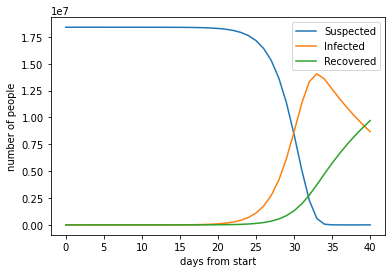

In [215]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
spreadRate = 2.3
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#Average day detect a person infected
detectDay = 5

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/14

#time that a infected begin spread
beginSpread = 2

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
NewInfecteds = np.array([I])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1+1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      if I[area_iter1] > 0:
        countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      if I[area_iter2] > 0:
        countICome = np.random.binomial(I[area_iter2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    if i < beginSpread:
      newInfected = 0
      recovered = 0
    elif i < detectDay:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area])
      #newInfected = spreadRate * S[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i, area]
    else:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area]-Is[i-detectDay, area])
      recovered = recoverRate * Is[i, area]
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
print(S)
print(I)
plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]


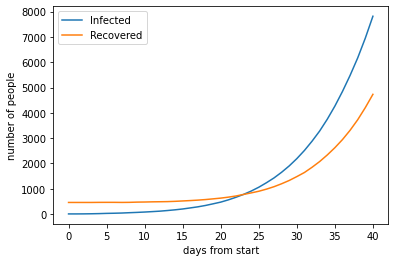

In [324]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger


#time that a infected begin spread
beginSpread = 2

#Average day detect a person infected
detectDay = 5

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
spreadRate = 2.3/(detectDay - beginSpread)
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/14

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
NewInfecteds = np.array([I])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1+1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      if I[area_iter1] > 0:
        countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      if I[area_iter2] > 0:
        countICome = np.random.binomial(I[area_iter2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  #for each region
  for area in range(6):
    if i < beginSpread:
      newInfected = 0
      recovered = 0
    elif i < detectDay:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area])
      #newInfected = spreadRate * S[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i, area]
    else:
      newInfected = spreadRate * S[area] / areaPopulation[area] * (Is[i-beginSpread, area]-Is[i-detectDay, area])
      recovered = recoverRate * Is[i, area]
    #update
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)
#plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

Initial State
S: [35653810 11008170  9350711  5939255 18390641 17290895]
I: [871  10  23   0   7  48]
R: [2839   56  950    0  460  198]


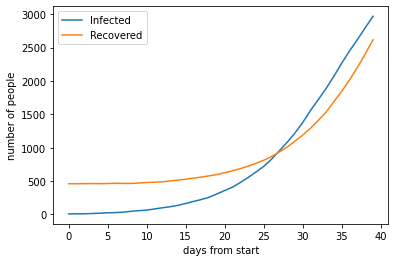

In [322]:
#initial state
initialDay = "2021-05-27"
#get recover number, include deaths
S = np.array(areaPopulation)
R = np.array([0,0,0,0,0,0])
I = np.array([0,0,0,0,0,0])
response = rqs.get("https://ncov.vncdc.gov.vn/v1/vietnam/province-type?start_time="+"2019-05-01"+"&end_time="+initialDay).json()
response = response['rows']
for row in range(len(response)):
  provinceName = response[row]["tinh"]
  areaCode = areaCodeDictionary[provinceName]
  R[areaCode - 1] += response[row]["ca_khoi"]+response[row]["tu_vong"]
  I[areaCode - 1] += response[row]["so_ca"]
  if response[row]["so_ca"] < response[row]["ca_khoi"]+response[row]["tu_vong"]:
    print(response[row])
S = S - I
I = I - R
print("Initial State")
print("S:", S)
print("I:",I)
print("R:", R)

#Graph:
#Vertice data: SIR table
#Edge weigth: flow_passenger

#time that a infected begin spread
beginSpread = 2

#Average day detect a person infected
detectDay = 5

#spread_rate (number of infected contacts that becoming infected)
#https://blog.vinbigdata.org/tim-hieu-ve-mot-mo-hinh-du-bao-dich-covid-19-tu-vu-han/?fbclid=IwAR3c5YWqwc6u3KjYj5u0mQP5arDrN52EXgOF2ihTqe1zJ96zMQo-9twG53s
commonSpreadRate = 2.3/(detectDay - beginSpread)
spreadRate = [commonSpreadRate] * 6
spreadRateScale = np.array([[1500, 2], [7000, 1.2]])
#With our calculating, 
#       the spread rate of covid 19 in Vietnam from 2019 to 2021-07-05 is 2.3,
#       but for credit purpose, we use 2.68

#infected time is average in 14 day
#https://thuvienphapluat.vn/van-ban/The-thao-Y-te/Quyet-dinh-1125-QD-BYT-2021-cham-soc-nguoi-benh-viem-duong-ho-hap-cap-do-vi-rut-SARS-CoV-2-464962.aspx
#7 day to become severe illness, and 7 more day to recover
#recover_rate (number of infected become recovered or death)
recoverRate = 1/14

Ss = np.array([S])
Is = np.array([I])
Rs = np.array([R])
NewInfecteds = np.array([I])
#for everyday calculate the change of SIR status in each region
sdate = date(2021, 5, 28)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
for i in range(delta.days + 1):
  day = sdate + timedelta(days=i)
  #transmit passengers
  for area_iter1 in range(5):
    for area_iter2 in range(area_iter1 + 1, 6):
      #probability of 1 people leaves the region area_iter1 and come to region area_iter2
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter1]
      #count number leave region 1 and come to region 2
      if I[area_iter1] > 0:
        countILeave = np.random.binomial(I[area_iter1], onePersonProb)
      else:
        countILeave = 0
      countRLeave = np.random.binomial(R[area_iter1], onePersonProb)
      #probability of 1 people leaves the region area_iter2 and come to region area_iter1
      onePersonProb = (flow_passenger[area_iter1, area_iter2]/2)/areaPopulation[area_iter2]
      #count number come to region 1 from region 2
      if I[area_iter2] > 0:
        countICome = np.random.binomial(I[area_iter2], onePersonProb)
      else:
        countICome = 0
      countRCome = np.random.binomial(R[area_iter2], onePersonProb)
      #arrived
      I[area_iter1] += countICome - countILeave
      I[area_iter2] += countILeave - countICome
      R[area_iter1] += countRCome - countRLeave
      R[area_iter2] += countRLeave - countRCome
      S[area_iter1] = areaPopulation[area_iter1] - I[area_iter1] - R[area_iter1]
      S[area_iter2] = areaPopulation[area_iter2] - I[area_iter2] - R[area_iter2]
  #SIR evolution
  NewInfecteds = np.insert(NewInfecteds, len(NewInfecteds), [0,0,0,0,0,0], axis=0)
  #for each region
  for area in range(6):
    if i < beginSpread:
      newInfected = 0
      recovered = 0
    elif i < detectDay:
      newInfected = spreadRate[area] * S[area] / areaPopulation[area] * (Is[i-beginSpread, area])
      #newInfected = spreadRatS[area] / areaPopulation[area] * Is[i-5,area]
      recovered = recoverRate * Is[i, area]
    else:
      newInfected = spreadRate[area] * S[area] / areaPopulation[area] * (Is[i-beginSpread, area]-Is[i-detectDay, area])
      recovered = recoverRate * Is[i, area]
    if newInfected < 0:
      newInfected = 0
    if recovered < 0:
      recovered = 0
    #update
    NewInfecteds[i, area] = newInfected
    R[area] += recovered
    I[area] += newInfected - recovered
    S[area] = areaPopulation[area] - I[area] - R[area]
    if I[area] > spreadRateScale[0, 0]:
      spreadRate[area] = spreadRateScale[0,1] / (detectDay - beginSpread)
    if I[area] > spreadRateScale[1, 0]:
      spreadRate[area] = spreadRateScale[1,1] / (detectDay - beginSpread)
  #add to trace of SIR through time
  Ss = np.insert(Ss, len(Ss), S, axis=0)
  Is = np.insert(Is, len(Is), I, axis=0)
  Rs = np.insert(Rs, len(Rs), R, axis=0)

#plt.plot(range((edate - sdate).days + 1+1),Ss[:,4], label="Suspected")
plt.plot(range((edate - sdate).days + 1+1),Is[:,4], label="Infected")
plt.plot(range((edate - sdate).days + 1+1),Rs[:,4], label="Recovered")
plt.xlabel("days from start")
plt.ylabel("number of people")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.


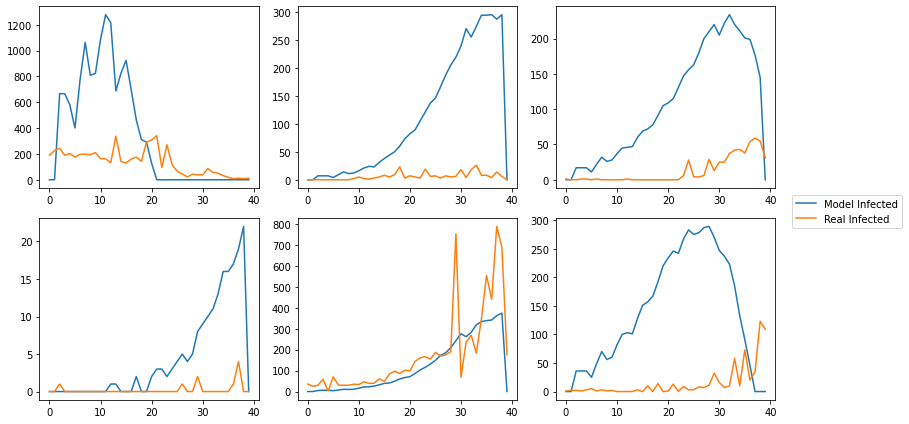

In [323]:
#build test data
sdate = date(2021, 5, 27)   # start date
edate = date(2021, 7, 5)   # end date
delta = edate - sdate       # as timedelta
dailyCaseInAreas = np.zeros((delta.days + 1, 6))
for row in range(1, len(covid)):
  strday = covid[row][2]
  day = datetime.strptime(strday, "%Y-%m-%d").date()
  index = (day - sdate).days
  if index < 0:
    continue
  provinceName = covid[row][1]
  areaCode = areaCodeDictionary[provinceName]
  dailyCaseInAreas[index, areaCode - 1] += int(covid[row][3])

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(11,6)
axs[0,0].plot(range((edate - sdate).days + 1),NewInfecteds[:,0], label="Model Infected")
axs[0,0].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 0], label="Real Infected")

axs[0,1].plot(range((edate - sdate).days + 1),NewInfecteds[:,1])
axs[0,1].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 1])

axs[0,2].plot(range((edate - sdate).days + 1),NewInfecteds[:,2])
axs[0,2].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 2])

axs[1,0].plot(range((edate - sdate).days + 1),NewInfecteds[:,3])
axs[1,0].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 3])

axs[1,1].plot(range((edate - sdate).days + 1),NewInfecteds[:,4])
axs[1,1].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 4])

axs[1,2].plot(range((edate - sdate).days + 1),NewInfecteds[:,5])
axs[1,2].plot(range((edate - sdate).days + 1),dailyCaseInAreas[:, 5])

fig.legend(loc=0, bbox_to_anchor=(1.15,0.55), bbox_transform=fig.transFigure)
fig.tight_layout()